In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/flan-t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, device_map="auto")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
model.to(dtype=torch.bfloat16)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [5]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
def run_flan_encode_decode(input_ids):
    encoder_outputs = model.encoder(input_ids)
    decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)
    return model.decoder(
        input_ids=decoder_input_ids,
        encoder_hidden_states=encoder_outputs.last_hidden_state,
    )

In [8]:
from lrp_engine import LRPEngine, checkpoint_hook

In [9]:
lrp = LRPEngine(use_gamma=True, dtype=torch.bfloat16)

In [10]:
prompt = "'Welcome to the final examination for this term's offering of CS100. Please remove all headphones and earbuds, as well as hats and hoods. Place your bag under your desk so that it does not block the aisle. You are permitted writing instruments, a clear water bottle, and any aids listed on the front of your booklet. The exam will be 150 minutes in duration. You may now begin.' How long is the exam?"
input_ids = tokenizer(prompt, return_tensors="pt").to(device)["input_ids"]

In [11]:
decoder_outputs = run_flan_encode_decode(input_ids)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [12]:
_, param_vals = lrp.run(decoder_outputs.last_hidden_state)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))


In [13]:
_, param_vals1 = lrp.run(decoder_outputs.last_hidden_state)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))


In [13]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((p1 - p0)**2).sum() for p1, p0 in zip(param_vals1, param_vals)
]

[tensor(1.3235e-23, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(2.5394e-20, device='cuda:0'),
 tensor(3.4245e-20, device='cuda:0')]

In [14]:
[ t.shape for t in param_vals ]

[torch.Size([1, 1]),
 torch.Size([1, 1]),
 torch.Size([1, 103]),
 torch.Size([103, 103])]

150 exam minutes duration long
torch.return_types.topk(
values=tensor([[3.4523e-04, 1.2875e-04, 1.2493e-04, 7.6294e-05, 7.2002e-05]],
       device='cuda:0'),
indices=tensor([[85, 82, 86, 88, 97]], device='cuda:0'))


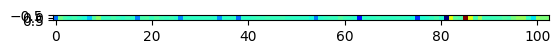

In [16]:
from matplotlib import pyplot as plt

plt.imshow(param_vals1[2].float().cpu(), cmap="jet")

print(tokenizer.decode(input_ids[0][param_vals1[2].float().topk(5).indices][0]))
print(param_vals1[2].float().topk(5))

In [17]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")

In [18]:
max_length = 0
for example in dataset["validation"].select(range(100)):
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]

    input_ids = tokenizer(context + " " + question, return_tensors="pt")["input_ids"]

    if input_ids.shape[-1] > max_length:
        max_length = input_ids.shape[-1]
print(max_length)

461


In [19]:
from tqdm import tqdm

results = []
top1_hits = 0
total_examples = 0

for example in tqdm(dataset["validation"]):
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]

    if not answers:
        continue

    input_ids = tokenizer(context + " " + question, return_tensors="pt")["input_ids"].to(device)
    if input_ids.shape[-1] > 512:
        continue
    
    output = run_flan_encode_decode(input_ids)

    _, param_vals = lrp.run(output.last_hidden_state)

    lrp_max = param_vals[2].flatten().argmax()
    lrp_top_token = tokenizer.convert_ids_to_tokens([input_ids[0][lrp_max]])[0].strip().replace(chr(9601), "")

    if any(lrp_top_token in ans for ans in answers):
        top1_hits += 1
    total_examples += 1
    if not (total_examples % 100):
        print(top1_hits, total_examples)
    # lrp_top5 = param_vals[2].flatten().topk(k=5)
    # lrp_top5_tokens = tokenizer.decode(input_ids[0][lrp_top5.indices.cpu()])
    # results.append({
    #     "example": example,
    #     "lrp_top5_tokens": lrp_top5_tokens,
    #     "lrp_top5_relevances": lrp_top5.values.cpu(),
    #     "is_impossible": len(answers) == 0
    # })

  2%|█▍                                                                            | 217/11873 [01:07<48:39,  3.99it/s]

92 100


  2%|█▌                                                                          | 239/11873 [01:15<1:01:26,  3.16it/s]


KeyboardInterrupt: 

In [19]:
for res in results:
    print("Q: ", res["example"]["question"])
    print("A (labels): ", res["example"]["answers"]["text"])
    print("LRP top5: ", res["lrp_top5_tokens"])
    print("LRP top5 attributions: ", res["lrp_top5_relevances"], '\n')

Q:  In what country is Normandy located?
A (labels):  ['France', 'France', 'France', 'France']
LRP top5:  France, region Norman country
LRP top5 attributions:  tensor([1.1452e-04, 4.3845e-05, 2.9287e-05, 1.8449e-05, 1.2439e-05]) 

Q:  When were the Normans in Normandy?
A (labels):  ['10th and 11th centuries', 'in the 10th and 11th centuries', '10th and 11th centuries', '10th and 11th centuries']
LRP top5:  10 first 10 people 11
LRP top5 attributions:  tensor([3.3029e-05, 2.2602e-05, 1.4791e-05, 1.1537e-05, 8.8099e-06]) 

Q:  From which countries did the Norse originate?
A (labels):  ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
LRP top5:  ers from raid,.
LRP top5 attributions:  tensor([5.3515e-05, 3.5023e-05, 8.7190e-06, 7.8946e-06, 6.2662e-06]) 

Q:  Who was the Norse leader?
A (labels):  ['Rollo', 'Rollo', 'Rollo', 'Rollo']
LRP top5:  Roll Iceland pirate leader,
LRP top5 attributions:  tensor([1.1889e-04, 